In [2]:
%matplotlib inline
import cv2
from skimage.filters import prewitt
from skimage.morphology import remove_small_objects
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil

In [15]:
def get_grid(image_path, threshold = 0.0025, remove_min_size=100000):
    image_rgb = cv2.imread(image_path)
    
    #read image in grayscale
    image = cv2.imread(image_path,0)
    
    #edge preserving smoothing
    im1 = cv2.bilateralFilter(image, 40, 500, 500)
    
    #eliminate differences in lighting by taking a gradient over the image
    im2  = prewitt(im1)
    
    #thresholding
    im3 = im2 > threshold
    
    #removing specks to preserve only the larger patch boundaries
    im4 = remove_small_objects(im3,min_size=remove_min_size)
    
    #converting bool to int
    im5 = np.int16(im4)
    
    return im5, image_rgb

#perspective transform for grids, either automatically or manually  
def warp_image(grid, plot_profiles= False, warp_points=None ):
    '''
    Inputs:
    - grid: binarized image of grid in int16
    - plot_profiles: plot the vertical and horizontal intensities
    - warp points: manually define corner points of the grid for warping
    
    Outputs:
    - dst: warped image
    - transform: transformed image 
    - pts1: detected corner points either automatic or manual
    '''
    pts2 = np.float32([[0,0],[grid.shape[1],0],[0,grid.shape[0]],[grid.shape[1],grid.shape[0]]])
    pts1 = pts2
    
    
    top = np.sum(grid[:1000, :], axis = 0)
    bottom = np.sum(grid[-1000:, :],axis=0)
    left = np.sum(grid[:,:750],axis=1)
    right = np.sum(grid[:, -750:],axis=1)
        
    if warp_points is None:
        top_h, ignore = find_peaks(top, height = np.max(top) * 0.25)
        bottom_h, ignore = find_peaks(bottom, height = np.max(bottom) * 0.25)
        left_v, ignore = find_peaks(left, height = np.max(left) * 0.25)
        right_v, ignore = find_peaks(right, height = np.max(right) * 0.25)

        tl_x = np.min(top_h) -10
        tl_y = np.min(left_v)-10
        tr_x = np.max(top_h) + 10
        tr_y = np.min(right_v)+ 10

        bl_x = np.min(bottom_h)-10
        bl_y = np.max(left_v) + 10
        br_x = np.max(bottom_h) + 10
        br_y = np.max(right_v) + 10

        pts1 = np.float32([[tl_x, tl_y], [tr_x, tr_y], [bl_x, bl_y], [br_x, br_y]])
    else:
        pts1 = warp_points
        
    if plot_profiles:
        
        plt.close()
        plt.plot(top,label="top")  
        plt.plot(bottom,label= "bottom")
        plt.title('Top & Bottom Intensities')
        #plt.legend
        plt.show()
        plt.plot(left,label="left")
        plt.plot(right,label= "right")
        #plt.legend()
        plt.title('Left & Right Intensities')
        plt.show()

    transform = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(grid.astype(np.float32),transform,(grid.shape[1],grid.shape[0]))
    
    return dst, transform, pts1

#splitting images into individual patches
def chop_image(image_path, plot_profiles = False, 
               threshold = 0.0025, 
               remove_min_size=100000, 
               peak_fraction_thresh = 0.5,
               warp_points = None,
               horizontal_distance_threshold = 500, 
               vertical_distance_threshold = 500, 
               expected_h = 3, 
               expected_v = 6,
               save = False):
    """Chop images and plot them on a grid
    
    Inputs
    - image_path: path to the image file in .jpg format
    - plot_profiles: plot the vertical and horizontal intensities
    - threshold: threshold value for binarizing grid image
    - remove_min_size: minimum size of artifacts to be removed from grid image
    - peak_fraction_thresh: minimum fraction of peak in vertical and horizontal intensities
    - warp_points = None,
    - horizontal_distance_threshold = minimum distance between peaks in horizontal intensity plot, 
    - vertical_distance_threshold = minimum distance between peaks in vertical intensity plot, 
    - expected_h = expected number of horizontal patches + 1, 
    - expected_v = expected number of vertical patches in grid + 1,
    - save = Boolean, save patches to subfolder
    """
    grid, image_rgb = get_grid(image_path, threshold, remove_min_size)
    warped_grid, transform, pts = warp_image(grid, plot_profiles, warp_points)
    
    warped_image = cv2.warpPerspective(image_rgb.astype(np.float32), \
                                       transform,(grid.shape[1],grid.shape[0]))
   
    #adding all intensities on the X axis
    horizontal = np.sum(warped_grid, axis=0)
    vertical = np.sum(warped_grid, axis = 1)
    
    h_pos, h_heights = find_peaks(horizontal, \
                                  height = np.max(horizontal) * peak_fraction_thresh, \
                                  distance = horizontal_distance_threshold)
    v_pos, v_heights = find_peaks(vertical, \
                                  height = np.max(vertical) * peak_fraction_thresh, \
                                  distance = vertical_distance_threshold)

    print("Image Name", image_path, "\nImage dimensions: ", len(h_pos), len(v_pos))
    
    if plot_profiles:
        plt.plot(horizontal ,'-r')
        plt.title(' horizontal intensities')
        plt.show()
        plt.plot(vertical, '-g')
        plt.title('vertical intensities')
        plt.show()
    
    if len(h_pos)!= expected_h or len(v_pos)!= expected_v:
        print("ERROR")
        shutil.copyfile(image_path, \
                        image_path.split('/')[0]+ "/review/" + image_path.split('/')[1])
        return warped_image, warped_grid, grid, h_pos, v_pos, pts

    
        
    for h in range(len(h_pos)-1) :
        for v in range(len(v_pos)-1):
            
            start_h = h_pos[h]
            end_h = h_pos[h+1]

            start_v = v_pos[v]
            end_v = v_pos[v+1]
            
            
            image_idx = str((len(v_pos) - 1) * h + v + 1)
            
            new_file_name =  ''.join(   [   '/'.join(image_path.split('/')[:-1]),
                                            '/patches/', 
                                            image_path.split('/')[-1].split('.jpg')[0],
                                            '_',  image_idx , '.jpg'] )
            
            if save:
                cv2.imwrite(new_file_name, warped_image[start_v:end_v,start_h:end_h, :],)
            
    if plot_profiles:
        plt.clf()
        plt.cla()
        plt.close()
        plt.imshow(np.int16(warped_image), cmap = 'gray')
        for v in v_pos:
            plt.hlines(v, 0, warped_grid.shape[1], 'g')
        for h in h_pos:
            plt.vlines(h,0,warped_grid.shape[0], 'r')
        plt.savefig('temp.jpg')
        
        
    return   warped_image, warped_grid, grid, h_pos, v_pos, pts

#retrieve all files from a folder
def get_files(folder, pattern):
    filenames = glob.glob(folder + '/' + pattern + '*')
    for file in filenames:
        chop_image(file, plot_profiles = False, 
               threshold = 0.0020, 
               remove_min_size=10000, 
               peak_fraction_thresh = 0.30, 
               warp_points =  None, #pts,
               horizontal_distance_threshold = 500, 
               vertical_distance_threshold = 500,
               expected_h = 3, 
               expected_v = 6,
               save = True)


In [ ]:
get_files('03-15-2019/', '*.jpg')

Image Name 03-15-2019/010-1988-B1.jpg 
Image dimensions:  3 6
Image Name 03-15-2019/010-1988-B2.jpg 
Image dimensions:  3 5
ERROR
Image Name 03-15-2019/010-1988-C2.jpg 
Image dimensions:  3 7
ERROR
Image Name 03-15-2019/012-1985-ACDS.jpg 
Image dimensions:  3 7
ERROR
Image Name 03-15-2019/010-1988-C1.jpg 
Image dimensions:  4 6
ERROR
Image Name 03-15-2019/015-1991-8.jpg 
Image dimensions:  3 5
ERROR
Image Name 03-15-2019/012-1985-3.jpg 
Image dimensions:  3 6
Image Name 03-15-2019/013-1988-C1.jpg 
Image dimensions:  4 6
ERROR
Image Name 03-15-2019/012-1985-2.jpg 
Image dimensions:  3 7
ERROR
Image Name 03-15-2019/014-1961-8.jpg 
Image dimensions:  4 6
ERROR
Image Name 03-15-2019/012-1985-B2.jpg 
Image dimensions:  3 7
ERROR
Image Name 03-15-2019/015-1991-hair.jpg 
Image dimensions:  3 5
ERROR
Image Name 03-15-2019/013-1988-C2.jpg 
Image dimensions:  3 6
Image Name 03-15-2019/012-1985-1.jpg 
Image dimensions:  3 6
Image Name 03-15-2019/011-1987-5 cont.jpg 
Image dimensions:  4 5
ERROR
I

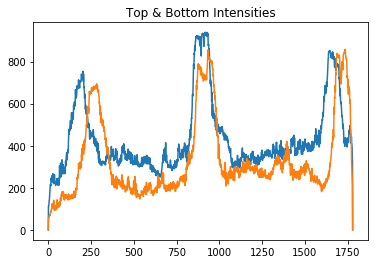

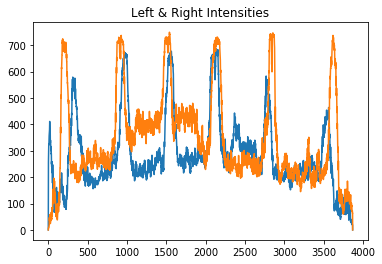

(3868, 1780)
[  54  875 1689] [  39  787 1426 2098 2881 3794]
05-24-2019/020-1.jpg 3 6


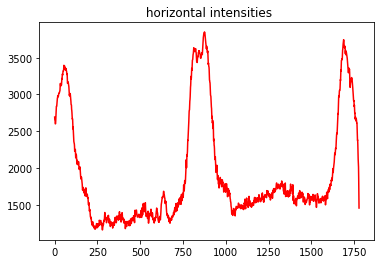

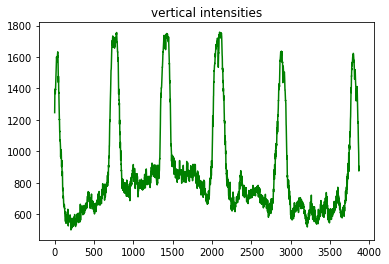

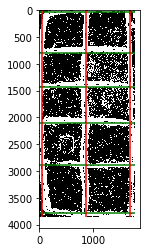

In [6]:
image_path = '05-24-2019/020-1.jpg'

warped_image, warped_grid, grid, h_pos, v_pos, pts = \
chop_image(image_path, plot_profiles = True, 
               threshold = 0.0020, 
               remove_min_size=1000, 
               peak_fraction_thresh = 0.350, 
               warp_points =  pts,
               horizontal_distance_threshold = 500, 
               vertical_distance_threshold = 500,
               expected_h = 3, 
               expected_v = 6,
               save = False) #True)